In [ ]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import torch
import torch.nn as nn
import torch.nn.functional as F
 
#for image conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
 
# for model
import torchvision.models as models
from torchvision import datasets, transforms
import os, shutil, time
 
# pd.options.display.max_seq_items = 2000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = 'content/drive/My Drive/Colab Notebooks/project'

In [ ]:
!cd drive


In [ ]:
!pwd
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/project')
!pwd


/content
/content/drive/My Drive/Colab Notebooks/project


In [ ]:
!ls


checkpoints  Dataset  images  outputs  testSetPlaces205_resize.tar.gz


In [ ]:
#!tar -xzf testSetPlaces205_resize.tar.gz

In [ ]:
!pwd


/content/drive/My Drive/Colab Notebooks/project


In [ ]:
!cd Dataset/

In [ ]:
!ls

checkpoints  Dataset  images  outputs  testSetPlaces205_resize.tar.gz


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/project


**here in our data set we have 41000 images so we have to move those images into train and validation folders**



In [ ]:
# os.makedirs('images/train/class/', exist_ok=True)
# os.makedirs('images/validation/class/', exist_ok=True)
# for num, file in enumerate(os.listdir('Dataset')):
#     if num < 1000:  # first 1000 will be moved to validation folder
#         os.rename('Dataset/' + file, 'images/validation/class/' + file)
#     else:
#         os.rename('Dataset/' + file, 'images/train/class/' + file)


**Now check the images by displaying those**

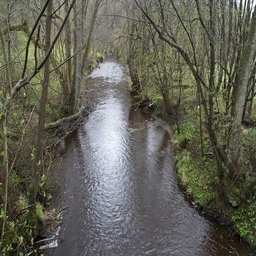

In [ ]:
from IPython.display import Image, display

#display any image that is present in our dataset
display(Image(filename='images/validation/class/00979cc09d3bb7ef8e07050889cc72f8.jpg'))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

True

**Now make our neutal network model**

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    # MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output


In [ ]:
model = ColorizationNet()

**Loss Function**

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0003, weight_decay=0.0)

**Loading the data**

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

In [ ]:
# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/validation' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)


In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count
 
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  print('graysclae',grayscale_input)
  # print('reados...',os.read(grayscale_input))
  print('dimgray',grayscale_input.shape)
  print('abinput',ab_input)
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

**Validation**

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()
 
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
 
  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)
 
    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
 
    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))
 
    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)
 
    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()
 
    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))
 
  print('Finished validation.')
  return losses.avg

**Training**

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()
  

In [ ]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 1

In [ ]:
for epoch in range(epochs):
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(),'checkpoints/model-epoch-{}-losses-{:.4f}.pth'.format(epoch+1,losses))

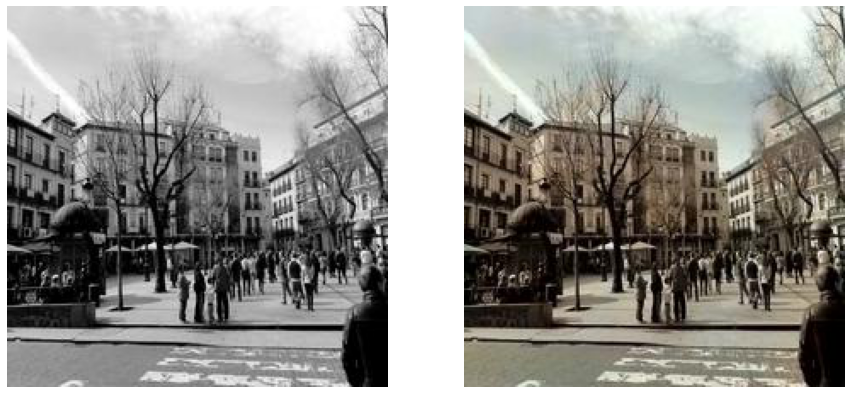

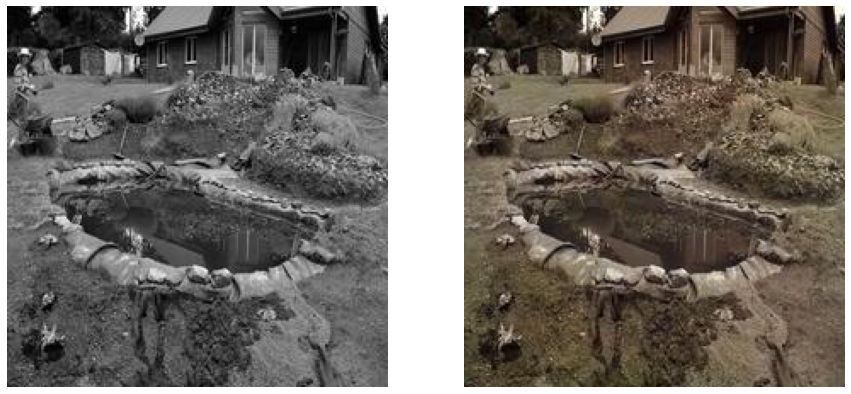

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-7-epoch-42.jpg', 'outputs/gray/img-7-epoch-42.jpg'),
               ('outputs/color/img-9-epoch-49.jpg', 'outputs/gray/img-9-epoch-49.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()


In [ ]:
save_images = True
with torch.no_grad():

  validate(val_loader, model, criterion, save_images, 0)
  print('graysclae',grayscale_input)
  # print('reados...',os.read(grayscale_input))
  print('dimgray',grayscale_input.shape)
  print('abinput',ab_input)

graysclae tensor([[[0.5095, 0.4571, 0.3717,  ..., 0.5182, 0.3773, 0.2507],
         [0.3991, 0.4725, 0.4882,  ..., 0.5720, 0.3518, 0.3840],
         [0.4523, 0.4980, 0.5512,  ..., 0.6608, 0.3569, 0.4073],
         ...,
         [0.2352, 0.3705, 0.4266,  ..., 0.0709, 0.0353, 0.0123],
         [0.2394, 0.2220, 0.2677,  ..., 0.0848, 0.0356, 0.0387],
         [0.3795, 0.1764, 0.1380,  ..., 0.0476, 0.0311, 0.0350]]])
dimgray torch.Size([1, 224, 224])
abinput tensor([[[0.2372, 0.2372, 0.3974,  ..., 0.4991, 0.3959, 0.3959],
         [0.2372, 0.2372, 0.3974,  ..., 0.4991, 0.3959, 0.3959],
         [0.4342, 0.4342, 0.5703,  ..., 0.5684, 0.4802, 0.4802],
         ...,
         [0.4611, 0.4611, 0.5921,  ..., 0.5214, 0.4211, 0.4211],
         [0.3125, 0.3125, 0.4669,  ..., 0.4266, 0.3597, 0.3597],
         [0.3125, 0.3125, 0.4669,  ..., 0.4266, 0.3597, 0.3597]],

        [[0.3645, 0.3645, 0.3934,  ..., 0.4333, 0.4008, 0.4008],
         [0.3645, 0.3645, 0.3934,  ..., 0.4333, 0.4008, 0.4008],
      

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 62 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


graysclae tensor([[[0.9107, 0.9079, 0.9017,  ..., 0.9393, 0.9342, 0.9381],
         [0.9026, 0.9026, 0.8995,  ..., 0.9331, 0.9309, 0.9381],
         [0.9026, 0.8989, 0.9028,  ..., 0.9331, 0.9331, 0.9381],
         ...,
         [0.8633, 0.8669, 0.8649,  ..., 0.9271, 0.9232, 0.9193],
         [0.8652, 0.8669, 0.8702,  ..., 0.9266, 0.9266, 0.9232],
         [0.8607, 0.8652, 0.8666,  ..., 0.9254, 0.9215, 0.9254]]])
dimgray torch.Size([1, 224, 224])
abinput tensor([[[0.1965, 0.1965, 0.3904,  ..., 0.5368, 0.4598, 0.4598],
         [0.1965, 0.1965, 0.3904,  ..., 0.5368, 0.4598, 0.4598],
         [0.4018, 0.4018, 0.5822,  ..., 0.5320, 0.4551, 0.4551],
         ...,
         [0.5005, 0.5005, 0.5951,  ..., 0.5456, 0.3921, 0.3921],
         [0.3358, 0.3358, 0.4739,  ..., 0.3953, 0.2922, 0.2922],
         [0.3358, 0.3358, 0.4739,  ..., 0.3953, 0.2922, 0.2922]],

        [[0.3938, 0.3938, 0.4180,  ..., 0.5114, 0.3984, 0.3984],
         [0.3938, 0.3938, 0.4180,  ..., 0.5114, 0.3984, 0.3984],
      

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished validation.


NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
graysclae tensor([[[0.6800, 0.6871, 0.6927,  ..., 0.4818, 0.4860, 0.4720],
         [0.6702, 0.6775, 0.6904,  ..., 0.4818, 0.4860, 0.4742],
         [0.6716, 0.6716, 0.6775,  ..., 0.4891, 0.4877, 0.4745],
         ...,
         [0.4021, 0.3783, 0.2511,  ..., 0.4700, 0.4543, 0.4568],
         [0.2694, 0.2192, 0.1924,  ..., 0.4588, 0.4745, 0.4686],
         [0.2058, 0.2070, 0.2059,  ..., 0.4798, 0.4952, 0.4874]]])